GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Observation spec: BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='observation', minimum=array([-1., -1., -8.], dtype=float32), maximum=array([1., 1., 8.], dtype=float32))
Action spec     : BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(-2., dtype=float32), maximum=array(2., dtype=float32))


2025-05-12 14:19:20.051075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


2025-05-12 14:19:25.057393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype resource
	 [[{{node Placeholder/_9}}]]
Episodes:   0%|                        | 0/1500 [00:00<?, ?it/s]

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/tmp/2632514/__autograph_generated_filerd8zulvz.py:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt((ag__.ld(policy_state) is ()), if_body_2, else_body_2, get_state_2, set_state_2, ('do_return', 'retval_'), 2)
/tmp/2632514/__autograph_generated_file6957alzc.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  retval_ = ag__.and_((lambda : (ag__.ld(state) is not None)), (lambda : ag__.and_((lambda : (ag__.ld(state) is not ())), (lambda : (ag__.ld(state) is not [])))))
/tmp/2632514/__autograph_generated_fileq9umf733.py:144: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  ag__.if_stmt(ag__.and_((lambda : (ag__.ld(input_state) is not ())), (lambda : ag__.ld(self)._layer_state_is_list[ag__.ld(i)])), if_body_4, else_body_4, get_state_4, set_state_4, ('input_state',), 1)
Episodes: 100%|███████████| 1500/1500 [1:08:06<00:00,  2.72s/it]


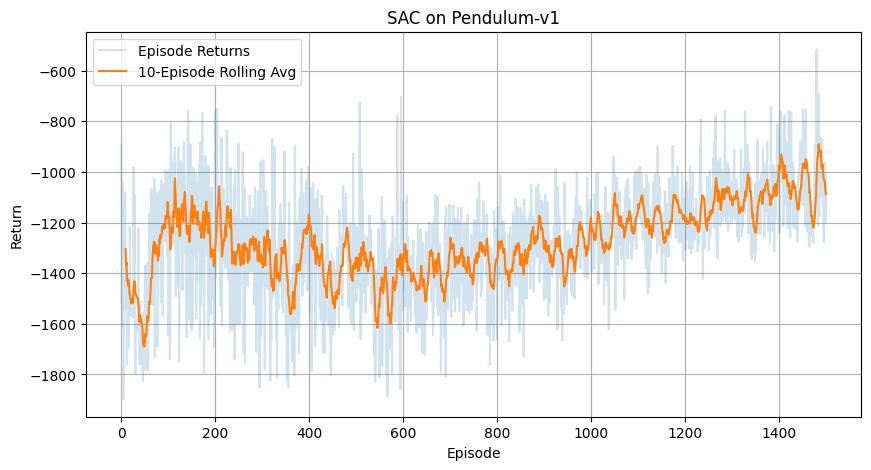

In [5]:
import os
import random
import numpy as np
import tensorflow as tf
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.agents.sac.sac_agent import SacAgent
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks import sequential, nest_map
from tf_agents.keras_layers import inner_reshape
from tf_agents.utils import common
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.trajectories import trajectory
from tqdm import trange
import matplotlib.pyplot as plt
import functools
from concurrent.futures import ThreadPoolExecutor

# --- (0) Seed and GPU configuration ---
# Suppress TensorFlow logging first thing
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all logs except ERROR (0=all, 1=info, 2=warning, 3=error)

# --- Setting up Random seed ---
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except RuntimeError:
        pass


# --- (1) Critic constructor (from TF-Agents SAC example) ---
dense = functools.partial(
    tf.keras.layers.Dense,
    activation=tf.keras.activations.relu,
    kernel_initializer='glorot_uniform',
)

def create_identity_layer():
    return tf.keras.layers.Lambda(lambda x: x)

def create_fc_network(units):
    return sequential.Sequential([dense(u) for u in units])

def create_sequential_critic_network(obs_units, act_units, joint_units):
    def split(inputs):
        return {'observation': inputs[0], 'action': inputs[1]}

    obs_net   = create_fc_network(obs_units)   if obs_units   else create_identity_layer()
    act_net   = create_fc_network(act_units)   if act_units   else create_identity_layer()
    joint_net = create_fc_network(joint_units) if joint_units else create_identity_layer()
    value_layer = tf.keras.layers.Dense(1, kernel_initializer='glorot_uniform')

    return sequential.Sequential([
        tf.keras.layers.Lambda(split),
        nest_map.NestMap({'observation': obs_net, 'action': act_net}),
        nest_map.NestFlatten(),
        tf.keras.layers.Concatenate(),
        joint_net,
        value_layer,
        inner_reshape.InnerReshape(current_shape=[1], new_shape=[]),
    ], name='sequential_critic')

# --- (2) Build environments & networks ---
train_py_env = suite_gym.load("Pendulum-v1")
train_env    = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env     = tf_py_environment.TFPyEnvironment(suite_gym.load("Pendulum-v1"))

print("Observation spec:", train_env.observation_spec())
print("Action spec     :", train_env.action_spec())

actor_net = ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(256, 256)
)

critic_net1 = create_sequential_critic_network((256,256), None, (256,256))
critic_net2 = create_sequential_critic_network((256,256), None, (256,256))

# --- (3) SAC Agent setup ---
train_step = tf.Variable(0)
agent = SacAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net1,
    critic_network_2=critic_net2,
    actor_optimizer=tf.keras.optimizers.Adam(3e-4),
    critic_optimizer=tf.keras.optimizers.Adam(3e-4),
    alpha_optimizer=tf.keras.optimizers.Adam(3e-4),
    target_update_tau=0.005,
    target_update_period=1,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=0.99,
    reward_scale_factor=1.0,
    train_step_counter=train_step
)

agent.initialize()

# --- (4) Replay buffer and initial seeding ---
buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000
)
random_policy = RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

# Seed with 1000 random transitions
ts = train_env.reset()
for _ in range(1000):
    a_step = random_policy.action(ts)
    nts = train_env.step(a_step.action)
    buffer.add_batch(trajectory.from_transition(ts, a_step, nts))
    ts = nts

dataset = buffer.as_dataset(sample_batch_size=256, num_steps=2).prefetch(3)
iterator = iter(dataset)

# --- (5) DynamicEpisodeDriver for collection ---
episode_driver = DynamicEpisodeDriver(
    env=train_env,
    policy=agent.collect_policy,  # already a TFPolicy
    observers=[buffer.add_batch],
    num_episodes=1
)

# --- (6) ThreadPoolExecutor for parallel data collection ---
def collect_episode(env, policy, buffer):
    ts = env.reset()
    total_reward = 0.0
    while not ts.is_last():
        action_step = policy.action(ts)  # The action_step will contain the action and info
        action = action_step.action  # Extract the action from the action_step
        ts_next = env.step(action)  # Take the action and get the next time step
        total_reward += ts_next.reward.numpy().item()
        
        # Create a trajectory using the correct values
        traj = trajectory.from_transition(ts, action_step, ts_next)
        buffer.add_batch(traj)  # Add the trajectory to the replay buffer
        
        ts = ts_next  # Update the current time step
    return total_reward


def collect_and_train_parallel():
    with ThreadPoolExecutor(max_workers=4) as executor:
        # Collect experiences in parallel
        futures = [executor.submit(collect_episode, train_env, agent.collect_policy, buffer) for _ in range(4)]
        for future in futures:
            future.result()  # Wait for the collection to complete

    # After collecting episodes, sample from buffer and train
    experience, _ = next(iterator)
    train_result = agent.train(experience)
    return train_result  # Return training result

# --- (7) Graph‐compiled collection + one train step ---
@tf.function
def collect_and_train():
    return collect_and_train_parallel()

# --- (8) Evaluation helper ---
def run_eval_episode():
    ts = eval_env.reset()
    total = 0.0
    while not ts.is_last():
        action = agent.policy.action(ts).action
        ts = eval_env.step(action)
        total += ts.reward.numpy().item()
    return total

# --- (9) Main loop with tqdm ---
num_episodes = 150
episode_returns = []

for episode in trange(num_episodes, desc="Episodes"):
    _, final_ts = collect_and_train()
    ret = run_eval_episode()
    episode_returns.append(ret)

# --- (10) Plot results ---
window = 10
rolling = np.convolve(episode_returns, np.ones(window)/window, mode='valid')
eps = np.arange(len(episode_returns))

plt.figure(figsize=(10,5))
plt.plot(eps, episode_returns, alpha=0.2, label='Episode Returns')
plt.plot(eps[window-1:], rolling, label=f'{window}-Episode Rolling Avg')
plt.title('SAC on Pendulum-v1')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()



In [4]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)
    

In [3]:
os.cpu_count()

40

2025-05-16 18:26:35.901188: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 18:26:36.443019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 18:26:38.705040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Usando GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2025-05-16 18:26:43.874679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
2025-05-16 18:27:10.228456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype resource
	 [[{{node Placeholder/_7}}]]
2025-05-16 18:27:10.228823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype resource
	 [[{{node Placeholder/_9}}]]
Seed 0:   0%|        | 0/50001 [00:00<?, ?it/s, eval_return=N/A]2025-05-16 18:27:15.180950: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:530] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in com

[Step     0] Eval return = -11.48


Seed 0:  10%| | 5005/50001 [03:59<12:24:24,  1.01it/s, eval_retu

[Step  5000] Eval return = -40.41


Seed 0:  20%|▏| 10004/50001 [07:40<12:45:37,  1.15s/it, eval_ret

[Step 10000] Eval return = -70.51


Seed 0:  30%|▎| 15004/50001 [11:22<10:20:33,  1.06s/it, eval_ret

[Step 15000] Eval return = -72.06


Seed 0:  40%|▍| 20004/50001 [15:03<8:48:32,  1.06s/it, eval_retu

[Step 20000] Eval return = -22.10


Seed 0:  50%|▌| 25005/50001 [18:44<6:55:07,  1.00it/s, eval_retu

[Step 25000] Eval return = -3.60


Seed 0:  60%|▌| 30003/50001 [22:26<7:50:15,  1.41s/it, eval_retu

[Step 30000] Eval return = -0.96


Seed 0:  70%|▋| 35004/50001 [26:08<4:08:58,  1.00it/s, eval_retu

[Step 35000] Eval return = -2.03


Seed 0:  80%|▊| 40005/50001 [29:50<2:45:41,  1.01it/s, eval_retu

[Step 40000] Eval return = -2.29


Seed 0:  90%|▉| 45004/50001 [33:32<1:36:12,  1.16s/it, eval_retu

[Step 45000] Eval return = -2.06


Seed 0: 100%|█| 50001/50001 [37:13<00:00, 22.38it/s, eval_return

[Step 50000] Eval return = -2.16
Saved JSON to jsons/sac_0_20250516T190424.json


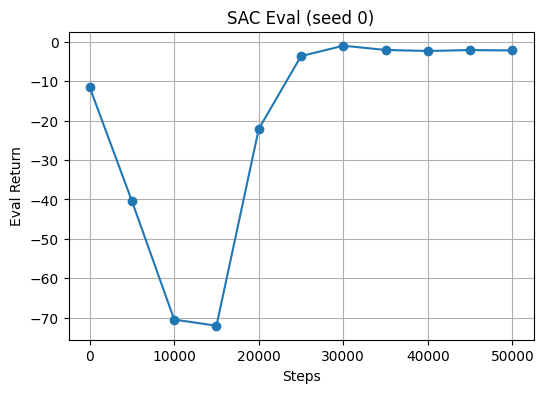

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import functools
import json
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import trange

from tf_agents.environments import suite_gym, ParallelPyEnvironment, tf_py_environment
from tf_agents.agents.sac.sac_agent import SacAgent
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks import sequential, nest_map
from tf_agents.keras_layers import inner_reshape
from tf_agents.utils import common
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.system import multiprocessing
multiprocessing.enable_interactive_mode()

# Habilitar uso de GPU
physical_devices = tf.config.list_physical_devices('GPU')
for g in physical_devices:
    tf.config.experimental.set_memory_growth(g, True)
print("Usando GPU:", tf.config.list_logical_devices('GPU'))

# --- Helper para construir red critic personalizada ---
dense = functools.partial(tf.keras.layers.Dense, activation='relu', kernel_initializer='glorot_uniform')

def create_identity_layer():
    return tf.keras.layers.Lambda(lambda x: x)

def create_sequential_critic_network(obs_units, act_units, joint_units):
    def split(inputs):
        return {'observation': inputs[0], 'action': inputs[1]}
    obs_net   = sequential.Sequential([dense(u) for u in obs_units]) if obs_units else create_identity_layer()
    act_net   = sequential.Sequential([dense(u) for u in act_units]) if act_units else create_identity_layer()
    joint_net = sequential.Sequential([dense(u) for u in joint_units]) if joint_units else create_identity_layer()
    value_layer = tf.keras.layers.Dense(1, kernel_initializer='glorot_uniform')
    return sequential.Sequential([
        tf.keras.layers.Lambda(split),
        nest_map.NestMap({'observation': obs_net, 'action': act_net}),
        nest_map.NestFlatten(),
        tf.keras.layers.Concatenate(),
        joint_net,
        value_layer,
        inner_reshape.InnerReshape(current_shape=[1], new_shape=[])
    ], name='sequential_critic')


def run_sac_seed(seed,
                 env_name = "MountainCarContinuous-v0",
                 #env_name=Pendulum-v1",
                 num_parallel=64*4,
                 collect_steps=128*2,
                 batch_size=256*4,
                 replay_buffer_max=200_000,
                 learning_rate=3e-4,
                 num_iterations=50_000,#50_000,
                 eval_interval=5_000):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

    def make_env(): return suite_gym.load(env_name)
    py_env = ParallelPyEnvironment([make_env] * num_parallel)
    train_env = tf_py_environment.TFPyEnvironment(py_env)
    eval_env  = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))

    with tf.device('/GPU:0'):
        train_step = tf.Variable(0)

        actor_net  = ActorDistributionNetwork(
            train_env.observation_spec(),
            train_env.action_spec(),
            fc_layer_params=(256,256)
        )
        critic_net1 = create_sequential_critic_network((256,256), None, (256,256))
        critic_net2 = create_sequential_critic_network((256,256), None, (256,256))

        agent = SacAgent(
            time_step_spec=train_env.time_step_spec(),
            action_spec=train_env.action_spec(),
            actor_network=actor_net,
            critic_network=critic_net1,
            critic_network_2=critic_net2,
            actor_optimizer=tf.keras.optimizers.Adam(learning_rate),
            critic_optimizer=tf.keras.optimizers.Adam(learning_rate),
            alpha_optimizer=tf.keras.optimizers.Adam(learning_rate),
            target_update_tau=0.003,
            target_update_period=5,
            td_errors_loss_fn=common.element_wise_squared_loss,
            gamma=0.99,
            reward_scale_factor=1.0,
            train_step_counter=train_step
        )
        agent.initialize()
        agent.train = common.function(agent.train)

    buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=agent.collect_data_spec,
        batch_size=num_parallel,
        max_length=replay_buffer_max
    )
    dataset = buffer.as_dataset(sample_batch_size=batch_size, num_steps=2).prefetch(tf.data.AUTOTUNE)
    iterator = iter(dataset)

    driver = dynamic_step_driver.DynamicStepDriver(
        train_env, agent.collect_policy, observers=[buffer.add_batch], num_steps=collect_steps
    )
    driver.run()  # Warm-up

    @tf.function
    def train_step_fn():
        experience, _ = next(iterator)
        return agent.train(experience)

    episodes = []
    evals = []
    ep_rewards = np.zeros(num_parallel)
    ep_steps = np.zeros(num_parallel, dtype=int)
    ep_count = np.zeros(num_parallel, dtype=int)

    def update_episodes(time_step):
        nonlocal ep_rewards, ep_steps, ep_count
        rewards = time_step.reward.numpy()
        dones = time_step.is_last().numpy()
        ep_rewards += rewards
        ep_steps += 1
        for i, done in enumerate(dones):
            if done:
                ep_count[i] += 1
                episodes.append({
                    "total_timesteps": int(ep_steps[i]),
                    "episode_num": int(ep_count[i]),
                    "episode_timesteps": int(ep_steps[i]),
                    "reward": float(ep_rewards[i])
                })
                ep_rewards[i] = 0.0
                ep_steps[i] = 0

    start_time = datetime.now().isoformat(timespec='seconds')

    pbar = trange(num_iterations + 1, desc=f"Seed {seed}", dynamic_ncols=True)
    pbar.set_postfix({"eval_return": "N/A"})
    for step in pbar:
        time_step, _ = driver.run()
        update_episodes(time_step)
        train_step_fn()

        if step % eval_interval == 0:
            ts = eval_env.reset(); total = 0.0
            while not ts.is_last():
                action_step = agent.policy.action(ts)
                ts = eval_env.step(action_step.action)
                total += ts.reward.numpy().item()
            evals.append({
                "at_timesteps": int(step),
                "evaluation_over_1_episode": float(total)
            })
            print(f"[Step {step:>5}] Eval return = {total:.2f}")
            pbar.set_postfix({"eval_return": f"{total:.2f}"})
            pbar.update(0)

    data = {
        "experiment": {
            "policy": "SAC",
            "environment": env_name,
            "seed": seed,
            "start_time": start_time
        },
        "episodes": episodes,
        "evaluations": evals
    }

    folder = "jsons"
    os.makedirs(folder, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%dT%H%M%S")
    fname = f"sac_{seed}_{ts}.json"
    path = os.path.join(folder, fname)
    with open(path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Saved JSON to {path}")

    return episodes, evals


def main():
    seeds = [0]
    for s in seeds:
        eps, evs = run_sac_seed(seed=s)
        steps = [e['at_timesteps'] for e in evs]
        vals = [e['evaluation_over_1_episode'] for e in evs]
        plt.figure(figsize=(6,4))
        plt.plot(steps, vals, marker='o')
        plt.xlabel('Steps'); plt.ylabel('Eval Return')
        plt.title(f'SAC Eval (seed {s})')
        plt.grid(True)
        plt.show()

if __name__ == '__main__':
    main()


In [ ]:
print('a')

In [ ]:
def main():
    seeds = [1]
    for s in seeds:
        eps, evs = run_sac_seed(seed=s)

        # Plot evaluation returns
        steps = [e['at_timesteps'] for e in evs]
        vals = [e['evaluation_over_1_episode'] for e in evs]
        plt.figure(figsize=(6, 4))
        plt.plot(steps, vals, marker='o', label='Eval Return')
        plt.xlabel('Steps')
        plt.ylabel('Eval Return')
        plt.title(f'SAC Eval (seed {s})')
        plt.grid(True)
        plt.legend()
        plt.show()

        window = 100
        rewards = [e['reward'] for e in eps]
        avg_rewards = [np.mean(rewards[i:i+window]) for i in range(0, len(rewards) - window + 1, window)]
        
        plt.plot(avg_rewards)
        plt.xlabel("Episode window (x100)")
        plt.ylabel("Avg reward per 100 episodes")
        plt.title("Smoothed Episode Rewards")
        plt.grid(True)
        plt.show()

main()
